### Import necessary libraries



In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from moviepy.editor import *
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1859584/45929032 bytes (4.0%)4366336/45929032 bytes (9.5%)6758400/45929032 bytes (14.7%)9527296/45929032 bytes (20.7%)12107776/45929032 bytes (26.4%)14565376/45929032 bytes (31.7%)16859136/45929032 bytes (36.7%)19398656/45929032 bytes (42.2%)21471232/45929032 bytes (46.7%)23887872/45929032 bytes (52.0%)26337280/45929032 bytes (57.3%)28983296/45929032 bytes (63.1%)314

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Images

In [3]:
imgInventory = "/content/drive/MyDrive/CSE428 Project/test_images/test/"
imgFiles = os.listdir(imgInventory) #keeps the names of the files
imgCatalogue = [] 
                  
for i in range(0, len(imgFiles)):
    imgCatalogue.append(plt.imread(imgInventory + imgFiles[i]))

### Display Images

In [4]:
# DISPLAY FUNCTION
def show_img(images, cmap=None):
    plt.figure(figsize=(35,35))
    for i, img in enumerate(images):
        plt.autoscale(tight=True)
        plt.subplot(1,2,i+1)
        plt.imshow(img, cmap)
        plt.axis("off")
    plt.show()

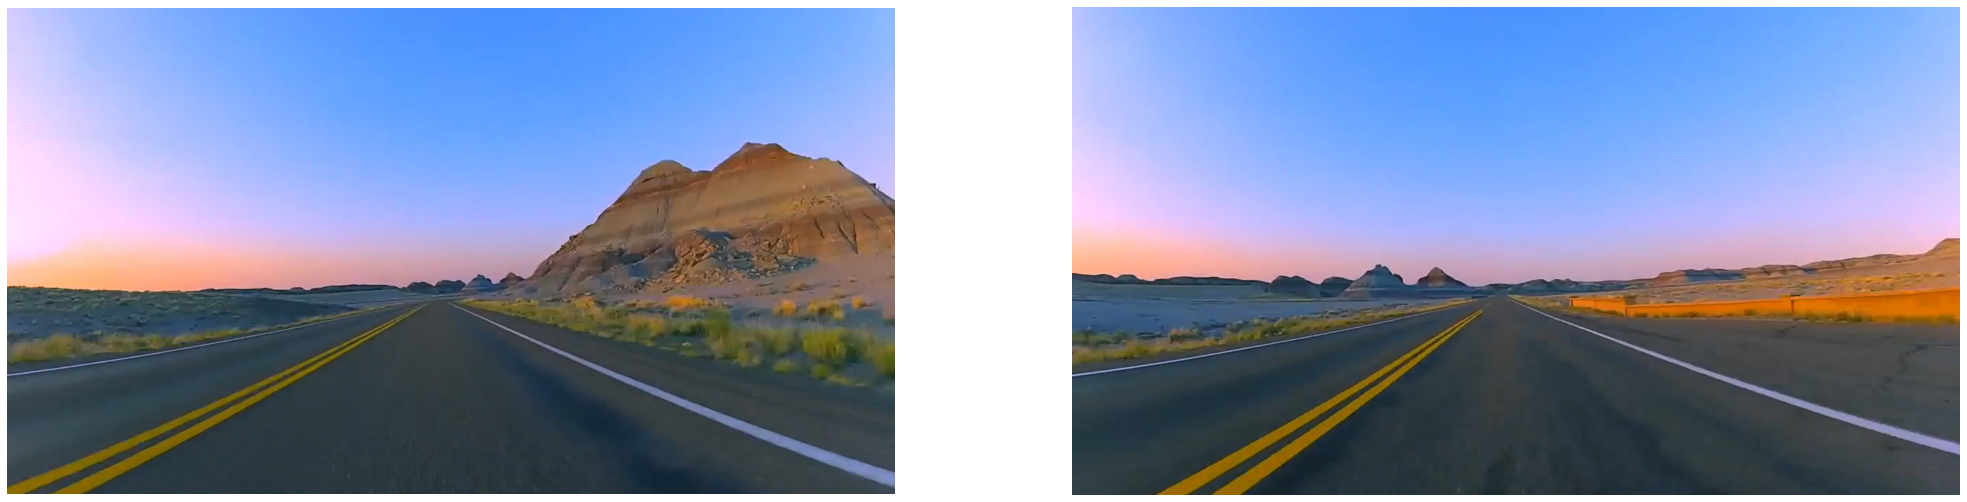

In [5]:
show_img(imgCatalogue)

In [6]:
def yw_filter(img):
    #converting from RGB to HLS color space
    imgHSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 

    yellowLow = np.array([10,0,90])
    yellowHigh = np.array([50,255,255])
    yellowFilter = cv2.inRange(imgHSL, yellowLow, yellowHigh)

    whiteLow = np.array([0,100,0])
    whiteHigh = np.array([255,255,255])
    whiteFilter = cv2.inRange(imgHSL, whiteLow, whiteHigh)

    mask = cv2.bitwise_or(whiteFilter, yellowFilter)
    target = cv2.bitwise_and(img, img, mask = mask)
    return target

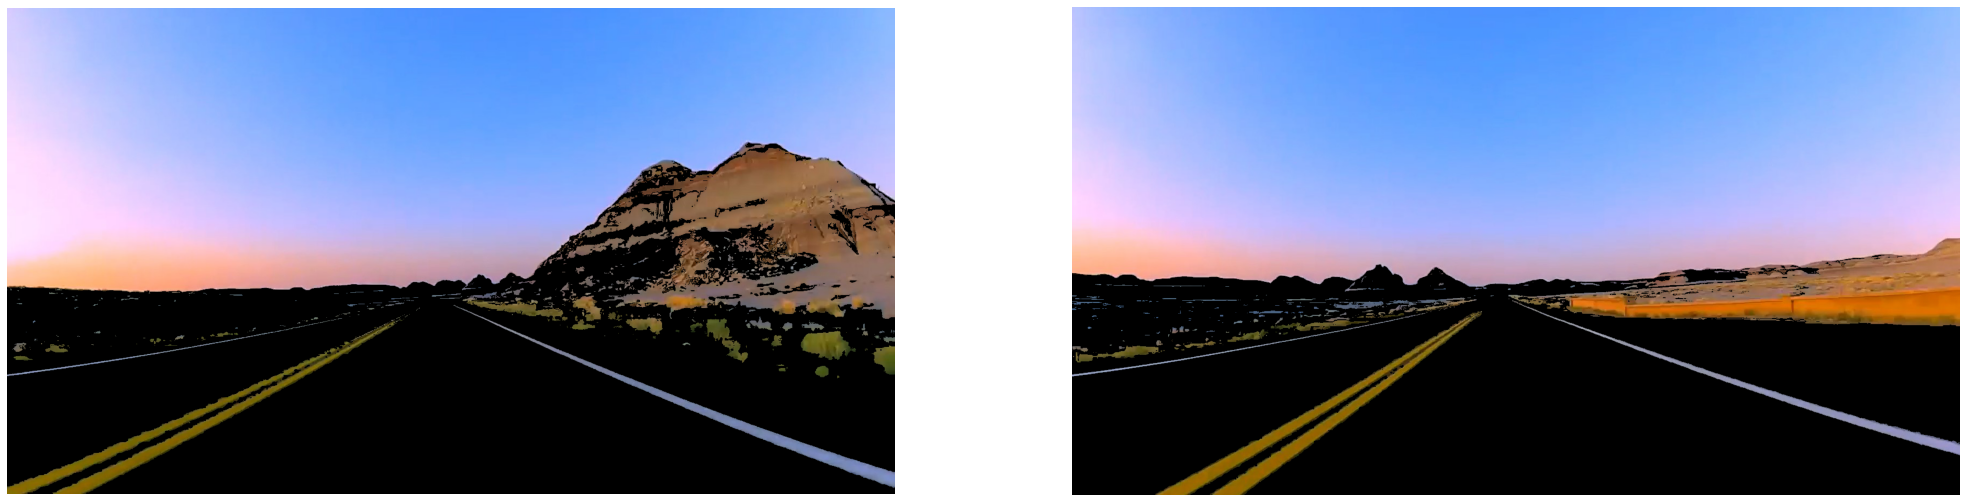

In [7]:
filtered_img = list(map(yw_filter, imgCatalogue))
show_img(filtered_img, cmap='gray') #Displaying the filtered img

In [8]:
#drawing the region of interests
def roi(img):
    w = int(img.shape[1]) #Width of the image
    h = int(img.shape[0]) #Height of the image
    #print(img.shape)
    black_img = np.zeros_like(img) #creating a black image with the same dimension as main image
    white_pixels = (255,255,255)
    shape = np.array([[int(0), int(h)], [int(w), int(h)], [int(w*0.55), int(h*0.6)], [int(w*0.45), int(h*0.6)]]) #these are the 4 coordinates of our region of interest
    #creates a polygon with the white pixels
    cv2.fillPoly(black_img, np.int32([shape]), white_pixels) #we are setting the pixel values to 255 inside our region of interest which we defined through the 4 coordinates
    target_image = cv2.bitwise_and(img, black_img) #taking all the common pixel values between main image and masked image
    return target_image

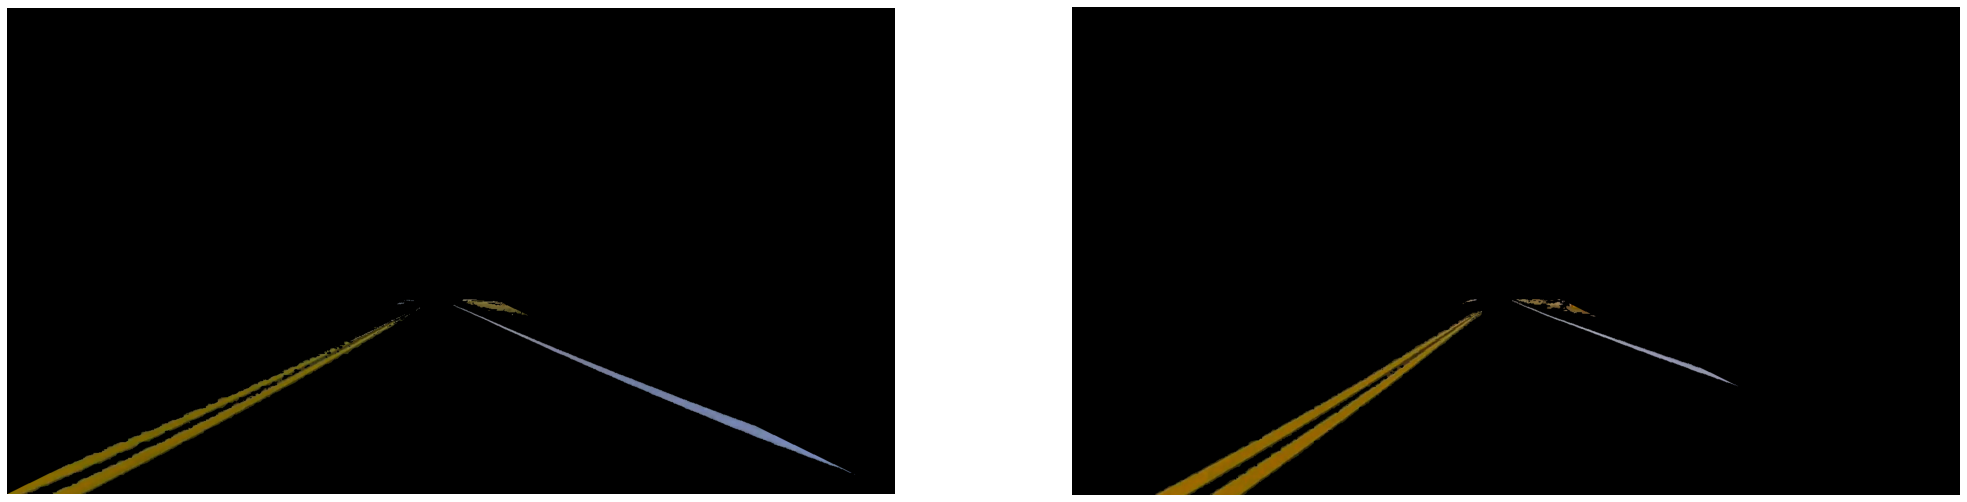

In [9]:
roi_img = list(map(roi, filtered_img))
show_img(roi_img)

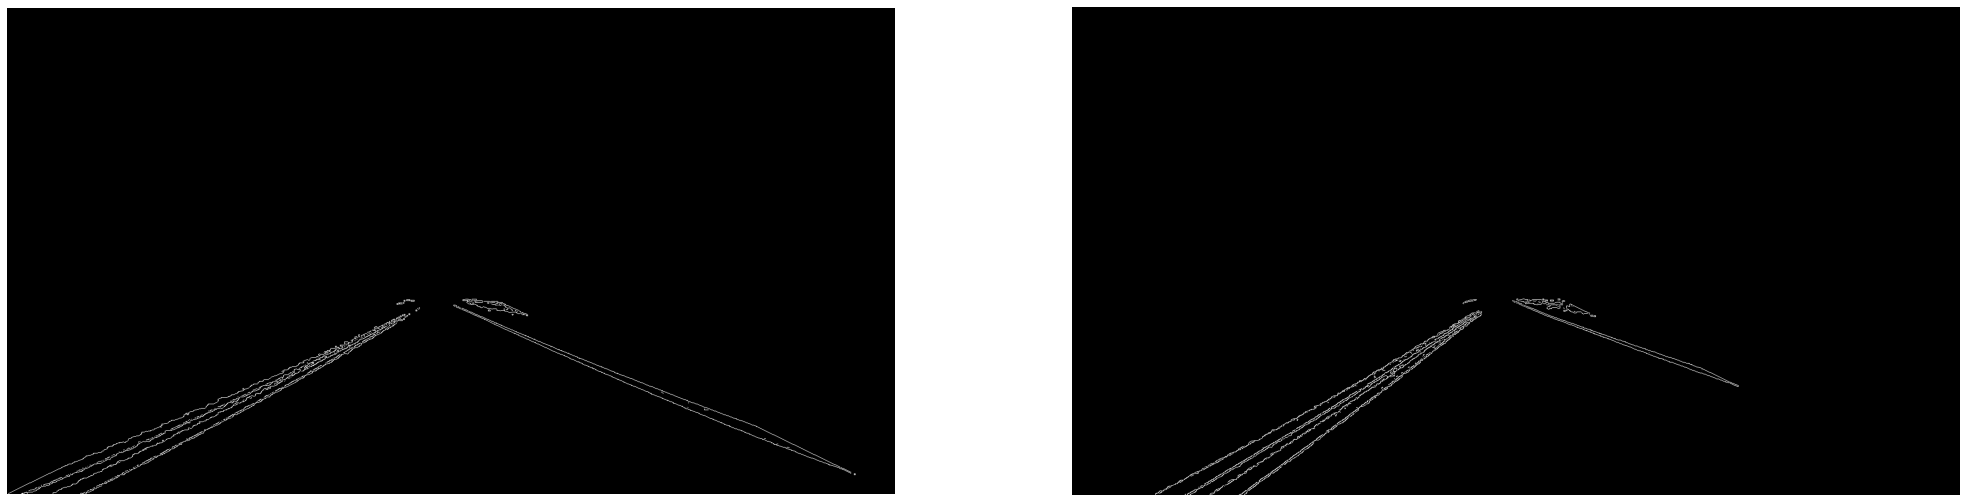

In [10]:
def canny(img):
    return cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 30, 80) # 30 and 80 are the 2 thresholds for hysteresis procedure

canny_img = list(map(canny, roi_img))
show_img(canny_img, cmap='gray')

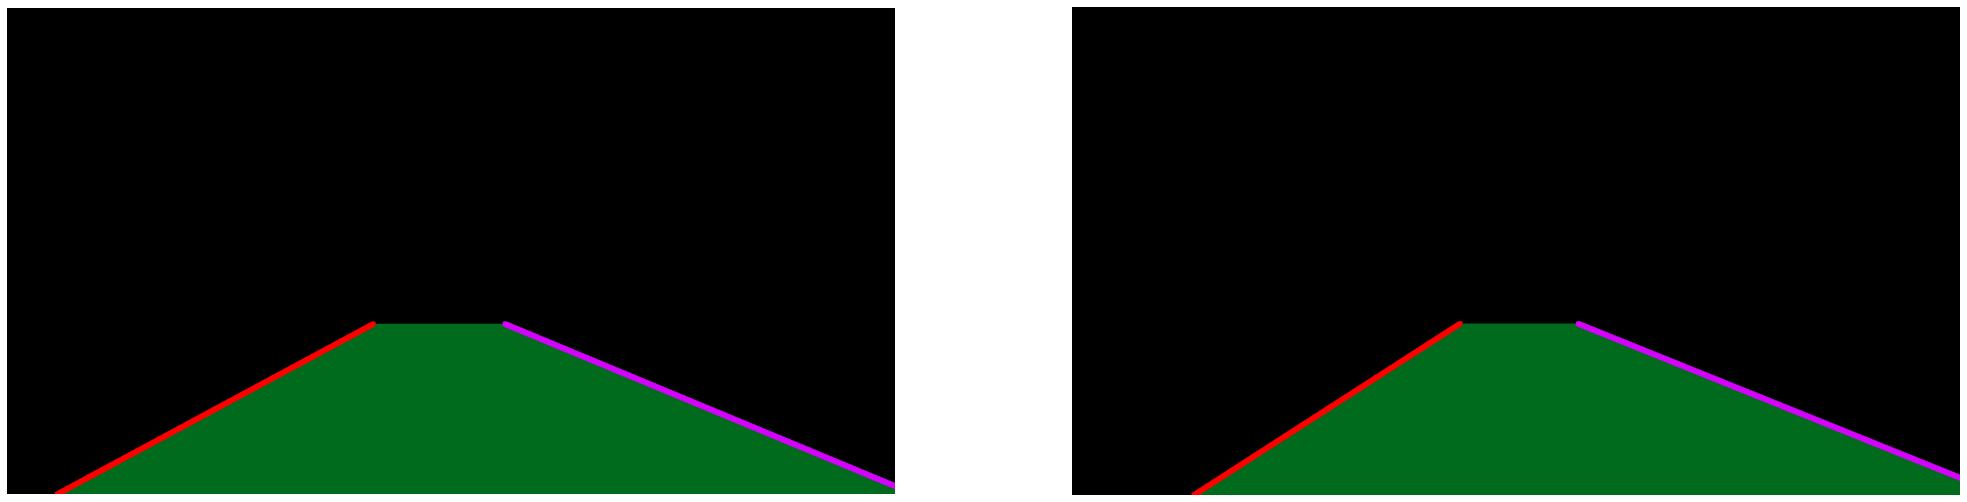

In [11]:
#Hough Line Detection

right_Slopes = []
right_Intercepts = []
left_Slopes = []
left_Intercepts = []

def laneDetection(img):
    global right_Slopes, left_Slopes, right_Intercepts, left_Intercepts

    lines = cv2.HoughLinesP(img, 1, np.pi/180, 10, np.array([]), minLineLength=20, maxLineGap=100) 
    #rho: The resolution parameter in pixels
    #theta: The resolution of the parameter in radians
    #threshold: The minimum number of intersecting points to detect a line
    #minLineLength - Line segments shorter than this are rejected
    #maxLineGap - Maximum allowed gap between line segments to treat them as single line
    img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    '''
    The outlier lines are removed as they can affect the average
    Then, using the slope we already calculated,
    we compute the points where the filtered lines intercepts y-axis
    '''
    #count = 0;
    if lines is not None:
        for line in lines:
            #count = count + 1
            for x1,y1,x2,y2 in line:
                slope = (y1-y2)/(x1-x2)
                if slope > 0.3 and x1 > 500: #for white line of the lane
                    y_interception = y2 - (slope * x2)
                    right_Intercepts.append(y_interception)
                    right_Slopes.append(slope)
                    #else: None
                elif slope < -0.3 and x1 < 600: #for yellow line of the lane
                    y_interception = y2 - (slope * x2)
                    left_Intercepts.append(y_interception)
                    left_Slopes.append(slope)
        #print("count", count)
    else:
      pass
    #taking average of the last 25 frames for steady lines
    left_avg_Slope = np.mean(left_Slopes[-25:])
    right_avg_Slope = np.mean(right_Slopes[-25:])
    left_avg_Interception = np.mean(left_Intercepts[-25:])
    right_avg_Interception = np.mean(right_Intercepts[-25:])
    #plotting lines using averages
    left_line_1 = int((0.65*img.shape[0] - left_avg_Interception)/left_avg_Slope)
    right_line_1 = int((0.65*img.shape[0] - right_avg_Interception)/right_avg_Slope)
    left_line_2 = int((img.shape[0] - left_avg_Interception)/left_avg_Slope)
    right_line_2 = int((img.shape[0] - right_avg_Interception)/right_avg_Slope)
    coordinates = np.array([[left_line_1, int(0.65*img.shape[0])],[left_line_2, int(img.shape[0])],[right_line_2, int(img.shape[0])],[right_line_1, int(0.65*img.shape[0])]])
    cv2.fillPoly(img, np.int32([coordinates]), (0, 107, 29)) #color of the detected lane 
    #drawing 2 colored lines as boundary
    cv2.line(img, (left_line_1, int(0.65*img.shape[0])), (left_line_2, int(img.shape[0])), [255, 0, 0], 10)
    cv2.line(img, (right_line_1, int(0.65*img.shape[0])), (right_line_2, int(img.shape[0])), [211, 3, 252], 10)
    return img

hough_img = list(map(laneDetection, canny_img))
show_img(hough_img)

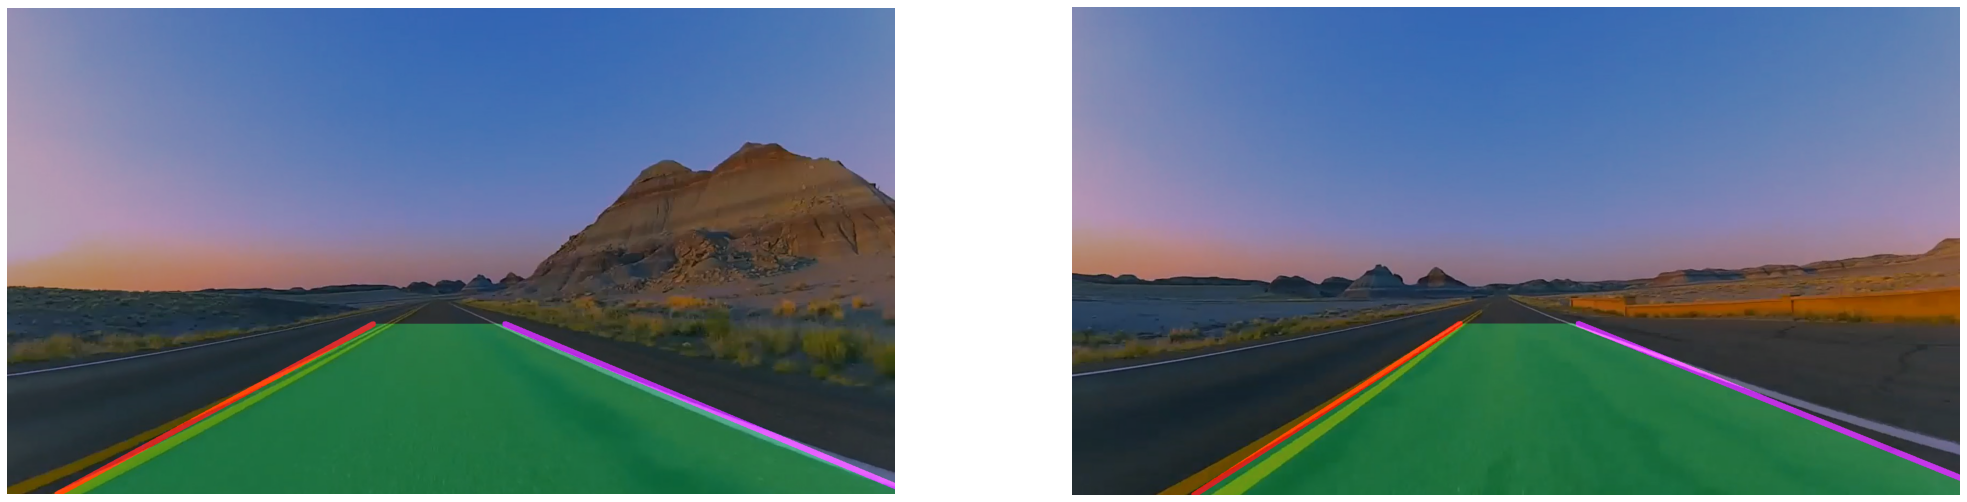

In [12]:
def cumulative_weighted_img(input_pair):
    img = list(input_pair)
    return cv2.addWeighted(img[0], 0.7, img[1], 0.7, 0.2)
    #return cv2.bitwise_or(img[0], img[1])

result_img = list(map(cumulative_weighted_img, zip(hough_img, imgCatalogue)))
show_img(result_img)

In [15]:
def frameProcessing(img):
    interest = roi(img)
    filtered= yw_filter(interest)
    canny = cv2.Canny(cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY), 50, 120)
    lines = laneDetection(canny)
    weighted_img = cv2.addWeighted(lines, 1, img, 1, 0)
    #weighted_img = cv2.bitwise_or(lines, image)
    return weighted_img

In [ ]:
inputDir = VideoFileClip("/content/drive/MyDrive/CSE428 Project/test_videos/test/Lane1.mp4")
outputDir = "/content/drive/MyDrive/CSE428 Project/video_output/Lane4.mp4"
resulted_video = inputDir.fl_image(frameProcessing) 
%time resulted_video.write_videofile(outputDir, audio=True)

[MoviePy] >>>> Building video /content/drive/MyDrive/CSE428 Project/video_output/Lane4.mp4
[MoviePy] Writing audio in Lane4TEMP_MPY_wvf_snd.mp3


100%|██████████| 138/138 [00:00<00:00, 643.01it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/CSE428 Project/video_output/Lane4.mp4



 94%|█████████▎| 176/188 [00:12<00:01, 11.68it/s]